# Test of application of corrections to pmaps

### JAH 17/10/18

<i>
    
This notebook applies corrections to pmaps to produce an energy spectrum.
    
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Nov 19 17:44:22 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number             = 6341
tag                    = "trigger2_v0.9.9_20180921_krbg1300" 
partitions              = ["{:04}".format(i) for i in range(0, 10)]
input_filenames        = [f"$IC_DATA/{run_number}/pmaps/trigger2/pmaps_{par}_{run_number}_{tag}.h5" for par in partitions]
#run_number             = 6206
# tag                    = "trigger2_v0.9.9_20180921_krbg1300" 
#input_hdst_filenames   = [f"$IC_DATA/{run_number}/pmaps/trigger2/Csphotopeak_6206_0.h5"]


# bootstrap correction
run_number_correction  = run_number
correction_filename    = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"
output_filename        = f"dfcorepeaks_{run_number}.h5"

In [4]:
print(input_filenames)

['$IC_DATA/6341/pmaps/trigger2/pmaps_0000_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0001_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0002_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0003_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0004_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0005_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0006_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0007_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0008_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '$IC_DATA/6341/pmaps/trigger2/pmaps_0009_6341_trigger2_v0.9.9_20180921_krbg1300.h5']


### Imports

In [5]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   invisible_cities.io.hits_io         import load_hits
from   invisible_cities.io.dst_io          import load_dst
import invisible_cities.io.pmaps_io        as pmio

import invisible_cities.database.load_db           as db

from invisible_cities.core .core_functions import in_range

import krcal.utils.hst_extend_functions   as hst
import krcal.dev.corrections              as corrections

import csth.utils.dfpmaps                as pmapdf
#import csth.utils.dfcepeaks              as cpkdf
import csth.utils.cepeak                 as cpk
import csth.utils.cepeak_pmaps_functions as cpkpmap
import csth.utils.cepeak_plot_functions  as cpkplot


In [6]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

## Input data

In [7]:
correction_filename = os.path.expandvars(correction_filename)
calibrate           = corrections.Calibration(correction_filename, 'scale')

datasipm   = db.DataSiPM(run_number)
xpos, ypos = datasipm.X.values, datasipm.Y.values

In [8]:
input_filenames = [os.path.expandvars(fi) for fi in input_filenames]
print(input_filenames)
#print(len(input_filenames), input_filenames[0])

['/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0000_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0001_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0002_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0003_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0004_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0005_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0006_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0007_6341_trigger2_v0.9.9_20180921_krbg1300.h5', '/Users/hernand

In [9]:
pmaps, runinfo = cpkpmap.data(input_filenames[0])

processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0000_6341_trigger2_v0.9.9_20180921_krbg1300.h5


In [10]:
#pmaps   = pmapdf.pmaps_from_hdf(input_filenames[0])
#runinfo = pmapdf.runfo_from_hdf(input_filenames[0])

In [11]:
spmaps  = pmapdf.filter_1s1(pmaps)
print(set(spmaps.s2['event']))

{318, 228, 293, 102, 262, 324, 107, 139, 300, 143, 16, 158}


## One event - Internal

In [12]:
evt, ipk = 318, 0
pmap = pmapdf.get_eventpeak(spmaps, evt, ipk)

In [13]:
epk = cpkpmap.epeak(pmap, xpos, ypos) 

nslices, nhits, q0, e0i, zi, xij, yij, zij, q0ij = epk

#nslices, hits     = epk.nslices, epk.nhits
#e0i, zi           = epk.e0i, epk.zi
#xij, yij, zij     = epk.xij, epk.yij, epk.zij
#q0ij              = epk.q0ij

print('epk, ipk', evt, ipk)
print('nslices, nhits', nslices, nhits)
print('q0, n0hits', q0)
print('e0, q0', np.sum(e0i), np.sum(q0ij))
print('x, y, z ', np.mean(xij), np.mean(yij), np.mean(zij))

epk, ipk 318 0
nslices, nhits 19 207
q0, n0hits 7852.9536
e0, q0 107962.26 5644.1973
x, y, z  57.56038647342995 82.29468599033817 159.24284


In [14]:
print(*zip(e0i, zi))

(20.554161, 150.94751) (513.69946, 151.70532) (2678.8064, 152.66351) (6685.861, 153.6175) (10302.866, 154.57178) (10753.935, 155.54541) (8614.766, 156.53595) (7711.2847, 157.56488) (9070.566, 158.57318) (11116.39, 159.56885) (11110.733, 160.54565) (9161.027, 161.53857) (7160.0454, 162.52826) (5429.522, 163.5326) (4070.6711, 164.51068) (2311.2983, 165.47675) (962.2103, 166.43988) (233.1898, 167.44818) (54.825043, 168.55621)


In [15]:
#print(*zip(xij, yij, zij, q0ij))

In [16]:
ceij, cqij = cpk._calibration_factors(xij, yij, zij, calibrate)
print(np.mean(ceij), np.mean(cqij))
#print(*zip(ceij, cqij))

1.0004326795897018 1.1100650569325776


In [17]:
ei, qi, eij, qij  = cpk._calibrate_hits(e0i, zi, zij, q0ij, ceij, cqij)
print(np.sum(ei), np.sum(qi), np.sum(eij), np.sum(qij))

107752.96925725622 6238.957174132459 107752.96925725622 6238.95717413246


In [18]:
print(*zip(ei, qi))
#print(*zip(eij, qij))

(0.0, 0.0) (513.2567474943228, 6.828183286375649) (2660.952770465278, 92.99778613048036) (6653.717739965928, 311.232473712377) (10260.908578136736, 558.1857663501197) (10720.167903317397, 660.4824554110071) (8597.977822729621, 536.8646973755987) (7690.511909255681, 470.9593551820508) (9045.167063667777, 510.4591585621104) (11090.633871990181, 643.5166844729134) (11117.967073429705, 655.2211066058884) (9187.770489380591, 572.5681604588568) (7186.859955016958, 442.4186734939706) (5436.277596885759, 329.5528490477791) (4084.2777281407257, 248.62026123929132) (2312.602242672694, 147.17617279340658) (959.5713398142357, 44.98465102509261) (234.34842489262422, 6.888738985140905) (0.0, 0.0)


In [19]:
ei = cpk._slices_energy(e0i, ei, qi)
print(*zip(ei, qi))

(20.528650283813477, 0.0) (513.2567474943228, 6.828183286375649) (2660.952770465278, 92.99778613048036) (6653.717739965928, 311.232473712377) (10260.908578136736, 558.1857663501197) (10720.167903317397, 660.4824554110071) (8597.977822729621, 536.8646973755987) (7690.511909255681, 470.9593551820508) (9045.167063667777, 510.4591585621104) (11090.633871990181, 643.5166844729134) (11117.967073429705, 655.2211066058884) (9187.770489380591, 572.5681604588568) (7186.859955016958, 442.4186734939706) (5436.277596885759, 329.5528490477791) (4084.2777281407257, 248.62026123929132) (2312.602242672694, 147.17617279340658) (959.5713398142357, 44.98465102509261) (234.34842489262422, 6.888738985140905) (54.756996154785156, 0.0)


In [20]:
#print(*zip(e0ij, q0ij))

In [21]:
x0, y0, z0, e0, q0h       = cpk.eqpoint(e0i, zi, xij, yij, q0ij)
print(x0, y0, z0, e0, q0h)

57.03461036200828 82.77539629615627 158.70236 107962.26 5644.1973


In [22]:
rmax, rsize               = cpk.radius(xij, yij, x0, y0)
zmin, zmax                = np.min(zi), np.max(zi)
print(rmax, rsize)
print(zmin, zmax, zmax - zmin)

123.4908903522847 38.60606166674714
150.94751 168.55621 17.608704


In [23]:
xu, yu, zu = cpk.upoint(zi, xij, yij)
print(xu, yu, zu)

e0f, e0b, ef, eb = cpk.eforbackward(e0i, ei, zi)
print(e0f, e0b, ef, eb)

60.0 75.0 159.57214
67468.73 40493.523 67253.82305730674 40574.43184638808


In [24]:
ep1, ep2, d12, e1, e2 = cpk.naiveblobs(eij, xij, yij, zij)
print('point1 ' , *ep1, 'eblob1 ', e1)
print('point2 ' , *ep2, 'eblob2 ', e2)
print('distance', d12)

point1  2964.24908592285 55.0 85.0 155.54541 eblob1  90719.92195414835
point2  542.0365421097055 65.0 75.0 164.51068 eblob2  8428.440113478533
distance 16.744434399943863


In [25]:
#uu = zip(eij, xij, yij, zij)
#uu = sorted(uu, reverse = True)
#print(uu)

In [26]:
x, y, z, e, qh            = cpk.eqpoint(ei , zi, xij, yij, qij)
print(x, y, z, e, qh)

56.90285380217951 82.78239956247748 158.71068309381542 107828.25490369482 6238.95717413246


In [27]:
noqslices      = qi <= 0
e0h = np.sum(e0i[~noqslices])
eh  = np.sum(ei [~noqslices])
q0h = np.sum(q0ij)
qh  = np.sum(qi [~noqslices])
zsize = zmax - zmin

In [28]:
fc = qh/q0h if q0h >0 else 0.
q  = q0 * fc
print(q0h, qh, fc)
print(q0 , q, q/q0)

5644.1973 6238.957174132459 1.1053754644845142
7852.9536 8680.462247856105 1.1053754644845142


In [29]:
cepk = cpk.CEPeak(nslices, nhits, q0, e0i, zi, xij, yij, zij, q0ij, ei, qi, eij, qij)

In [30]:
cepk2  = cpk.cepeak(epk, calibrate)

In [31]:
check = lambda x, y: np.all(x == y)
for var in ['nslices', 'nhits', 'q0', 'e0i', 'zi', 'xij', 'yij', 'zij', 'q0ij', 'ei', 'qi', 'eij', 'qij']:
    ok = check( getattr(cepk, var), getattr(cepk2, var))
    print(var, ok)


nslices True
nhits True
q0 True
e0i True
zi True
xij True
yij True
zij True
q0ij True
ei True
qi True
eij True
qij True


In [32]:
esum = cpk.esum(cepk, 0, 0, 0, 0)

In [33]:
print('nslices', esum.nslices, nslices)
print('nhits'  , esum.nhits  , nhits)

print('x0', x0, esum.x0  == x0)
print('x0', y0, esum.y0  == y0)
print('z0', z0, esum.z0  == z0)
print('e0', e0, esum.e0  == e0)
print('q0', q0, esum.q0  == q0)
print('e0h', e0h, esum.e0h == e0h)
print('q0h', q0h, esum.q0h == q0h)

print('x', x, esum.x == x)
print('y', y, esum.y == y)
print('z', z, esum.z == z)
print('e', e, esum.e == e)
print('q', q, esum.q == q)
print('eh', eh, esum.eh   == eh)
print('qh', qh, esum.qh   == qh)

print('rmax' , rmax,  esum.rmax  == rmax)
print('rsize', rsize, esum.rsize == rsize)
print('zmax' , zmax,  esum.zmax  == zmax)
print('zsize', zsize, esum.zsize == zsize)

nslices 19 19
nhits 207 207
x0 57.03461036200828 True
x0 82.77539629615627 True
z0 158.70236 True
e0 107962.26 True
q0 7852.9536 True
e0h 107886.875 True
q0h 5644.1973 True
x 56.90285380217951 False
y 82.78239956247748 False
z 158.71068309381542 True
e 107828.25490369482 True
q 8680.462247856105 True
eh 107752.9692572562 True
qh 6238.957174132459 True
rmax 123.4908903522847 True
rsize 38.60606166674714 True
zmax 168.55621 True
zsize 17.608704 True


In [34]:
print(esum)

 event: [0] 
  peak: [0] 
  location: 0 
  nslices: 19 
  nhits: 207 
  noqslices: 2 
  time: 0 
  s1e: 0 
  t0: 0 
  rmax: 123.4908903522847 
  rsize: 38.60606166674714 
  zmax: 168.55621 
  zsize: 17.608704 
  x0: 57.03461036200828 
  y0: 82.77539629615627 
  z0: 158.70236 
  e0: 107962.26 
  q0: 7852.9536 
  e0h: 107886.875 
  q0h: 5644.1973 
  x: 56.853218906960144 
  y: 82.86931450650748 
  z: 158.71068309381542 
  q: 8680.462247856105 
  e: 107828.25490369482 
  eh: 107752.9692572562 
  qh: 6238.957174132459 
  xu: 60.0 
  yu: 75.0 
  zu: 159.57214 
  e0f: 67468.73 
  e0b: 40493.523 
  ef: 67253.82305730674 
  eb: 40574.43184638808 
  e1: 660.4824554110071 
  x1: 35.0 
  y1: 95.0 
  z1: 155.54541 
  e2: 6.888738985140905 
  x2: 45.0 
  y2: 85.0 
  z2: 163.5326 
  eblob1: 6232.068435147319 
  eblob2: 6.888738985140905 
  d12: 16.24176978986534 
 


In [35]:
#t0 = time.time()
#esum =  cpk.ESum.zeros(0)
#for i in range(10000):
#    iesum = cpk.ESum.zeros()
#    esum = esum.append(iesum)
#esum.head()
#t1 = time.time()
#print('time difference ', t1-t0)

In [36]:
#for var in vars(cepk):
#    print(var, getattr(cepk, var))

In [37]:
## Time Studies

In [38]:
print('nslices', esum.nslices, nslices)
print('nhits'  , esum.nhits  , nhits)

print('x0', x0, esum.x0  == x0)
print('x0', y0, esum.y0  == y0)
print('z0', z0, esum.z0  == z0)
print('e0', e0, esum.e0  == e0)
print('q0', q0, esum.q0  == q0)
print('e0h', e0h, esum.e0h == e0h)
print('q0h', q0h, esum.q0h == q0h)

print('x', x, esum.x == x)
print('y', y, esum.y == y)
print('z', z, esum.z == z)
print('e', e, esum.e == e)
print('q', q, esum.q == q)
print('eh', eh, esum.eh   == eh)
print('qh', qh, esum.qh   == qh)

print('rmax' , rmax,  esum.rmax  == rmax)
print('rsize', rsize, esum.rsize == rsize)
print('zmax' , zmax,  esum.zmax  == zmax)
print('zsize', zsize, esum.zsize == zsize)

nslices 19 19
nhits 207 207
x0 57.03461036200828 True
x0 82.77539629615627 True
z0 158.70236 True
e0 107962.26 True
q0 7852.9536 True
e0h 107886.875 True
q0h 5644.1973 True
x 56.90285380217951 False
y 82.78239956247748 False
z 158.71068309381542 True
e 107828.25490369482 True
q 8680.462247856105 True
eh 107752.9692572562 True
qh 6238.957174132459 True
rmax 123.4908903522847 True
rsize 38.60606166674714 True
zmax 168.55621 True
zsize 17.608704 True


In [39]:
s1e, t0 = cpkpmap.s1_info(pmap.s1)
print(s1e, t0)

84.764084 498.93164737910166


In [40]:
timestamp = 0 if runinfo is None else runinfo[runinfo.evt_number == evt].timestamp.values[0]
print(timestamp)

1537691704093


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


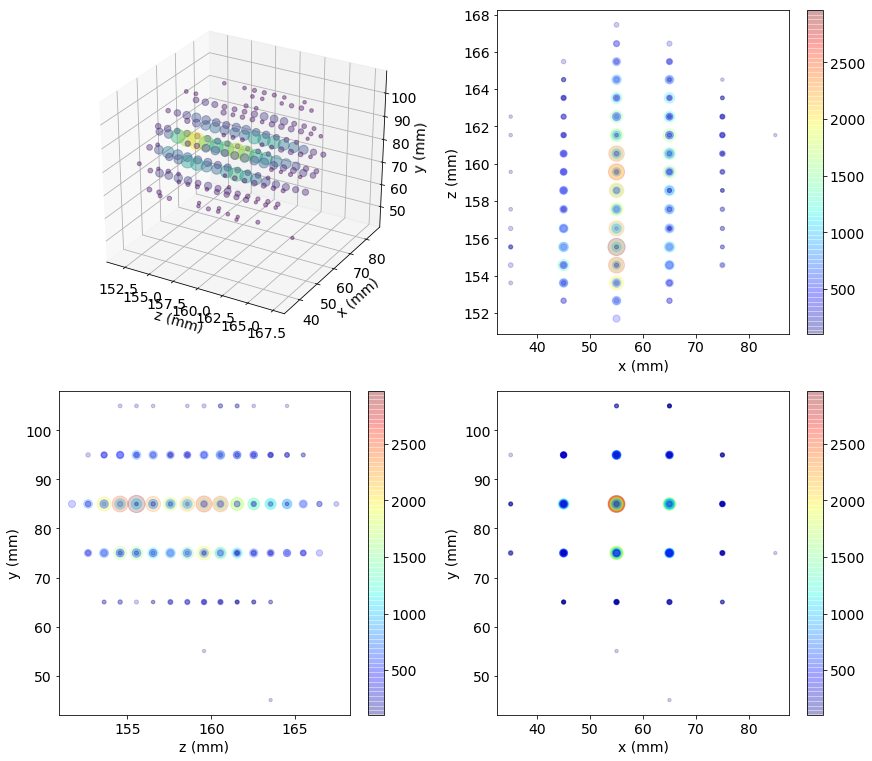

In [41]:
cpkplot.graph_event(xij, yij, zij, eij)

## Run a file

In [42]:
esums = cpk.ESum(10)
for iloc, pmap in pmapdf.epeak_iterator(spmaps):
    evt, ipk = iloc
    epk  = cpkpmap.epeak(pmap, xpos, ypos)
    cepk = cpk.cepeak(epk, calibrate)
    esum = cpk.esum(cepk, 0, 0, 0, 0)
    esums.set(esum, iloc)
print(esums)

 event: [ 16 102 107 139 143 158 228 228 262 293] 
  peak: [0 0 0 0 0 0 0 1 0 0] 
  location: [0 0 0 0 0 0 0 0 0 0] 
  nslices: [76 17 49 25 16 21 27 10 19 14] 
  nhits: [747 214 524 327 176 154 323  22 225 193] 
  noqslices: [7 4 6 7 4 6 3 4 4 2] 
  time: [0 0 0 0 0 0 0 0 0 0] 
  s1e: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
  t0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
  rmax: [205.54804791  47.4341649  226.38462845 176.7766953  123.49089035
  75.16648189 176.7766953  148.49242405 155.72411502 155.72411502] 
  rsize: [ 43.64183796  38.5042427   43.05206147 292.77623445  36.28967209
  30.0136944   35.55677151  19.26030207  34.50738626  61.01358818] 
  zmax: [258.13183594 231.10971069 440.04348755 445.50259399 300.84503174
 147.8460083  231.13345337 278.27963257 411.95843506 120.22735596] 
  zsize: [74.70947266 15.61291504 47.48925781 23.19006348 14.68530273 19.60406494
 25.49609375  8.29833984 17.4654541  12.42962646] 
  x0: [ -24.12232174   11.70721981 -142.89088337   -1.3003246    59.98858946
  -4

In [43]:
df = esums.df()
df.head()

,event,peak,location,nslices,nhits,noqslices,time,s1e,t0,rmax,...,x1,y1,z1,e2,x2,y2,z2,eblob1,eblob2,d12
0,16,0,0,76,747,7,0,0.0,0.0,205.548048,...,-45.0,175.0,185.451050,676.549951,-45.0,165.0,228.393311,5802.836184,2141.325886,44.091243
1,102,0,0,17,214,4,0,0.0,0.0,47.434165,...,-5.0,5.0,224.374237,0.000000,-15.0,-25.0,222.397369,7573.254317,0.000000,31.684507
2,107,0,0,49,524,6,0,0.0,0.0,226.384628,...,-155.0,-115.0,411.234039,204.990966,-165.0,-105.0,433.238007,5826.720480,1732.787934,26.156731
3,139,0,0,25,327,7,0,0.0,0.0,176.776695,...,-25.0,115.0,437.916718,1260.720480,-25.0,115.0,437.916718,9112.759834,0.000000,0.000000
4,143,0,0,16,176,4,0,0.0,0.0,123.490890,...,45.0,85.0,293.932861,1131.563793,45.0,85.0,293.932861,5681.548850,0.000000,0.000000


## run one file

In [44]:
output_filenmae = 'temp.h5'
counters, dat = cpkpmap.esum(input_filenames[0], 'temp.h5', correction_filename, run_number, 0, full = True)
print(*counters)

processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0000_6341_trigger2_v0.9.9_20180921_krbg1300.h5
14 14


In [45]:
esum, cepks = dat
esum.head()

,event,peak,location,nslices,nhits,noqslices,time,s1e,t0,rmax,...,x1,y1,z1,e2,x2,y2,z2,eblob1,eblob2,d12
0,16,0,0,76,747,7,1537691697241,332.304504,466.107964,205.548048,...,-45.0,175.0,185.451050,676.549951,-45.0,165.0,228.393311,5802.836184,2141.325886,44.091243
1,102,0,0,17,214,4,1537691699100,120.688301,434.086349,47.434165,...,-5.0,5.0,224.374237,0.000000,-15.0,-25.0,222.397369,7573.254317,0.000000,31.684507
2,107,0,0,49,524,6,1537691699338,321.762817,256.253823,226.384628,...,-155.0,-115.0,411.234039,204.990966,-165.0,-105.0,433.238007,5826.720480,1732.787934,26.156731
3,139,0,0,25,327,7,1537691700043,206.777161,225.565763,176.776695,...,-25.0,115.0,437.916718,1260.720480,-25.0,115.0,437.916718,9112.759834,0.000000,0.000000
4,143,0,0,16,176,4,1537691700105,113.503670,363.514837,123.490890,...,45.0,85.0,293.932861,1131.563793,45.0,85.0,293.932861,5681.548850,0.000000,0.000000


In [46]:
cepks[0].head()
cepks[1].head()
cepks[2].head()

,event,peak,xij,yij,zij,q0ij,eij,qij
0,16,0,-55.0,165.0,188.383118,6.022127,129.419530,7.032299
1,16,0,-55.0,165.0,189.368896,10.381000,210.390237,12.128582
2,16,0,-55.0,165.0,190.350281,7.800088,168.971028,9.117858
3,16,0,-55.0,165.0,200.405762,6.595663,162.733623,7.750523
4,16,0,-55.0,165.0,202.376892,7.685381,171.975304,9.040340


## run several files

In [47]:
output_filename = 'temp.h5'
xtime, ntot, nacc = [], 0, 0
for i, ifile in enumerate(input_filenames):
    t0 = time.time()
    counters, _ = cpkpmap.esum(ifile, output_filename, correction_filename, run_number, i, full = True)
    itot, iacc = counters
    t1 = time.time()
    ntot += itot
    nacc += iacc
    xtime.append(t1-t0)
xtime = np.array(xtime)
print(ntot, nacc, np.mean(xtime), np.sum(xtime)/nacc)

processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0000_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0001_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0002_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0003_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0004_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0005_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigger2/pmaps_0006_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /Users/hernando/investigacion/NEXT/data/runIV//6341/pmaps/trigge

# Output of corrected event peaks

In [48]:
time_full   = np.array([54.5, 53.6, 53.7])
time_nofill = np.array([52.5, 53.0, 52.7])
time_nocepk = np.array([21.3, 20.5, 19.1])
time_noepk  = np.array([19.4, 19.3, 19.9])

In [49]:
time_full   = np.array([60.1, 61.5, 59.3])
time_nofill = np.array([55.1, 55.0, 56.0])
time_nocepk = np.array([23.4, 23.6, 24.3])
time_noepk  = np.array([22.4, 22.3, 22.3])

In [50]:
time_full   = np.array([63., 61.1, 62.2])
time_nofill = np.array([57.5, 55.7, 56.2])
time_nocepk = np.array([24.2, 24.0, 23.8])
time_noepk  = np.array([22.9, 22.3, 22.2])

In [51]:
print(output_filename)
esum = cpk.esum_from_hdf(output_filename)

temp.h5


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


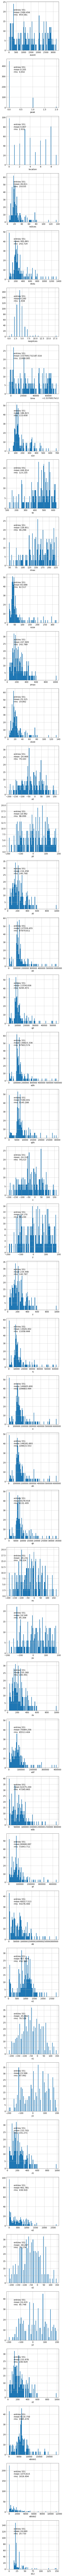

In [52]:
cpkplot.df(esum)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


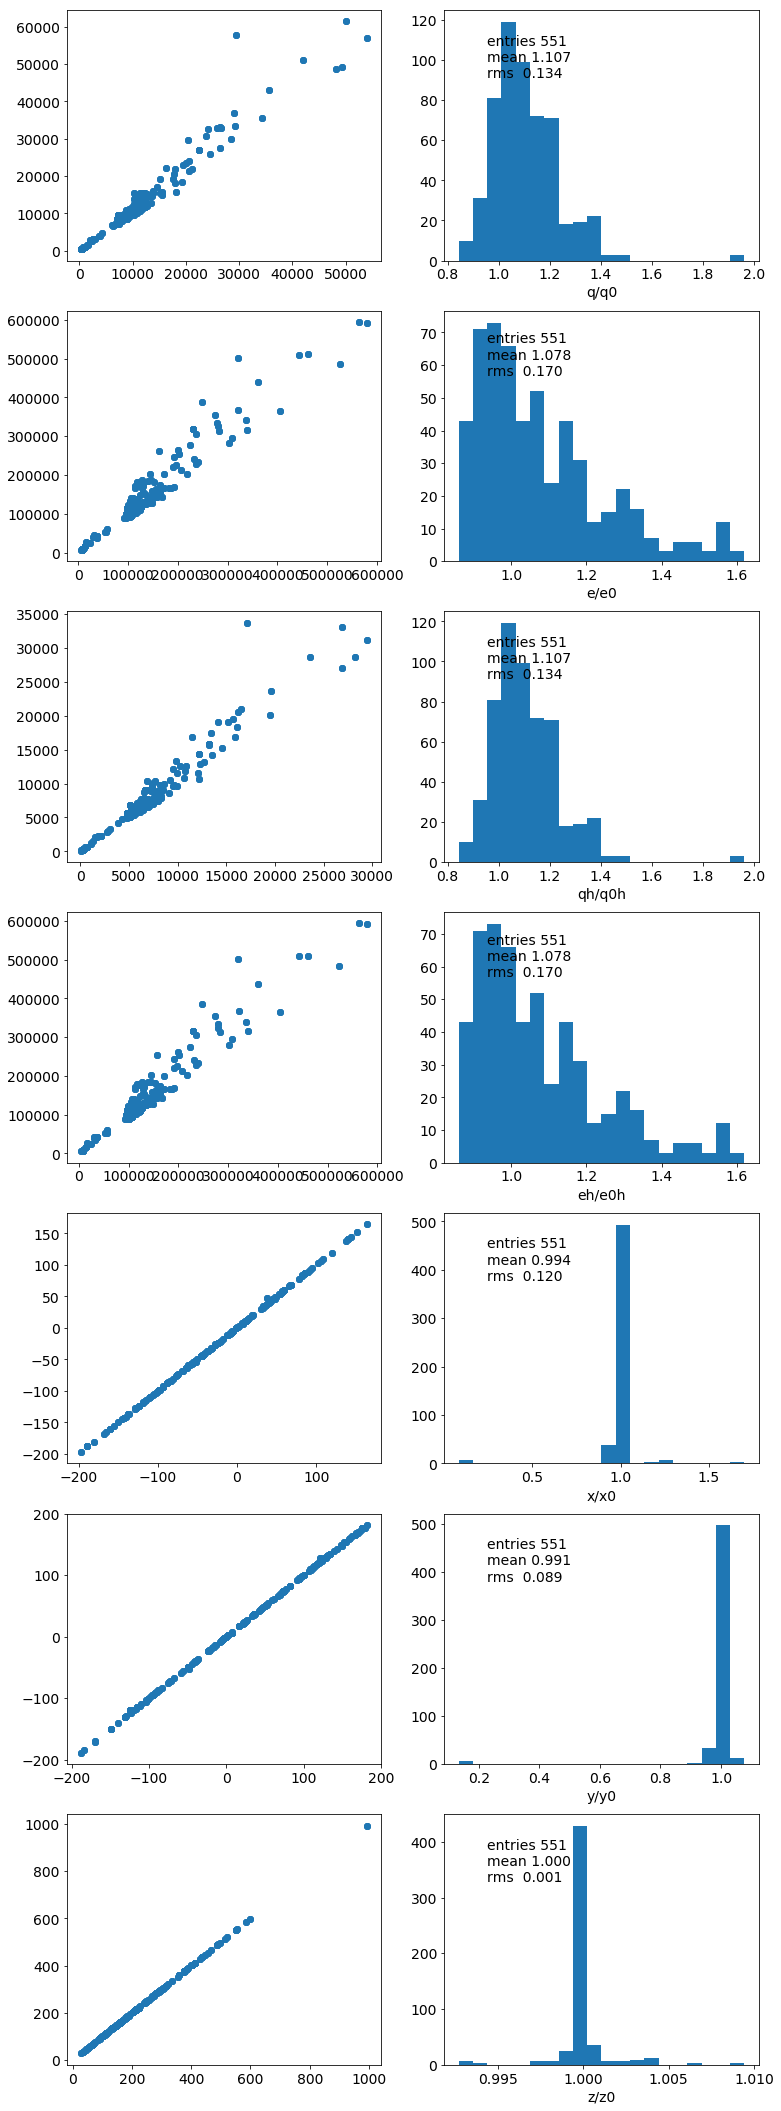

In [53]:
cpkplot.ratio(esum, [('q0', 'q'), ('e0', 'e'), ('q0h', 'qh'), ('e0h', 'eh'),
                    ('x0', 'x'), ('y0', 'y'), ('z0', 'z')], 20)

In [54]:
edf, sdf, hdf = cpk.cepks_from_hdf(output_filename)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


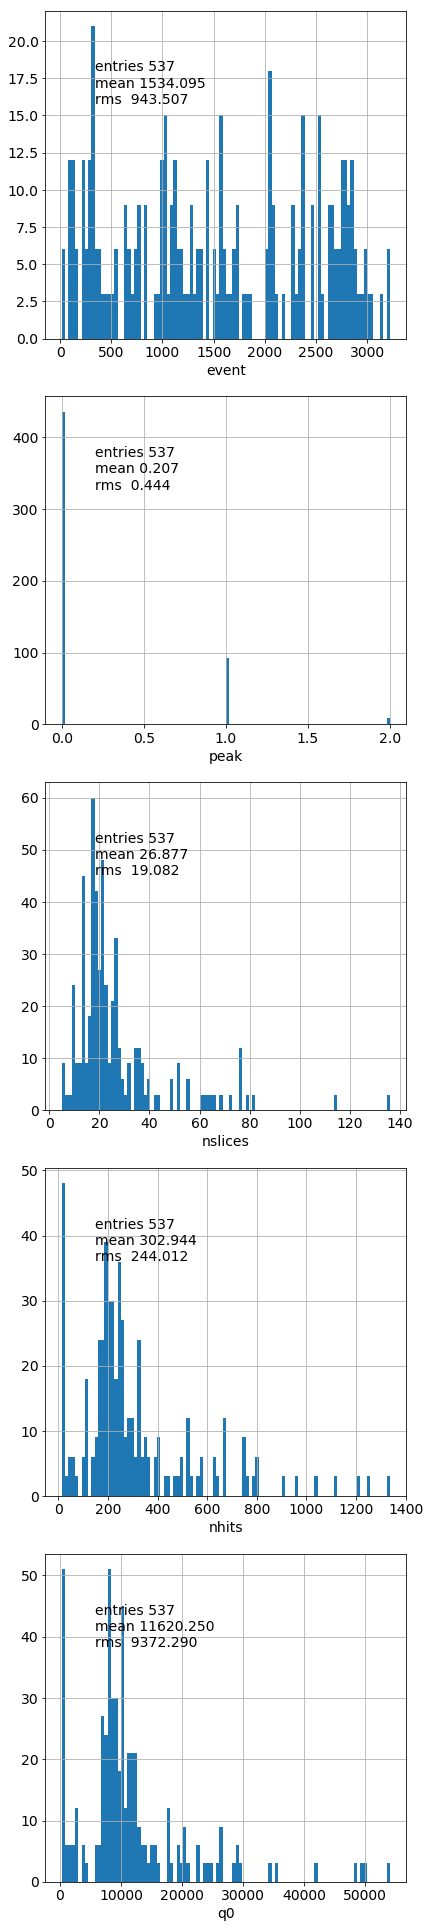

In [55]:
cpkplot.df(edf)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


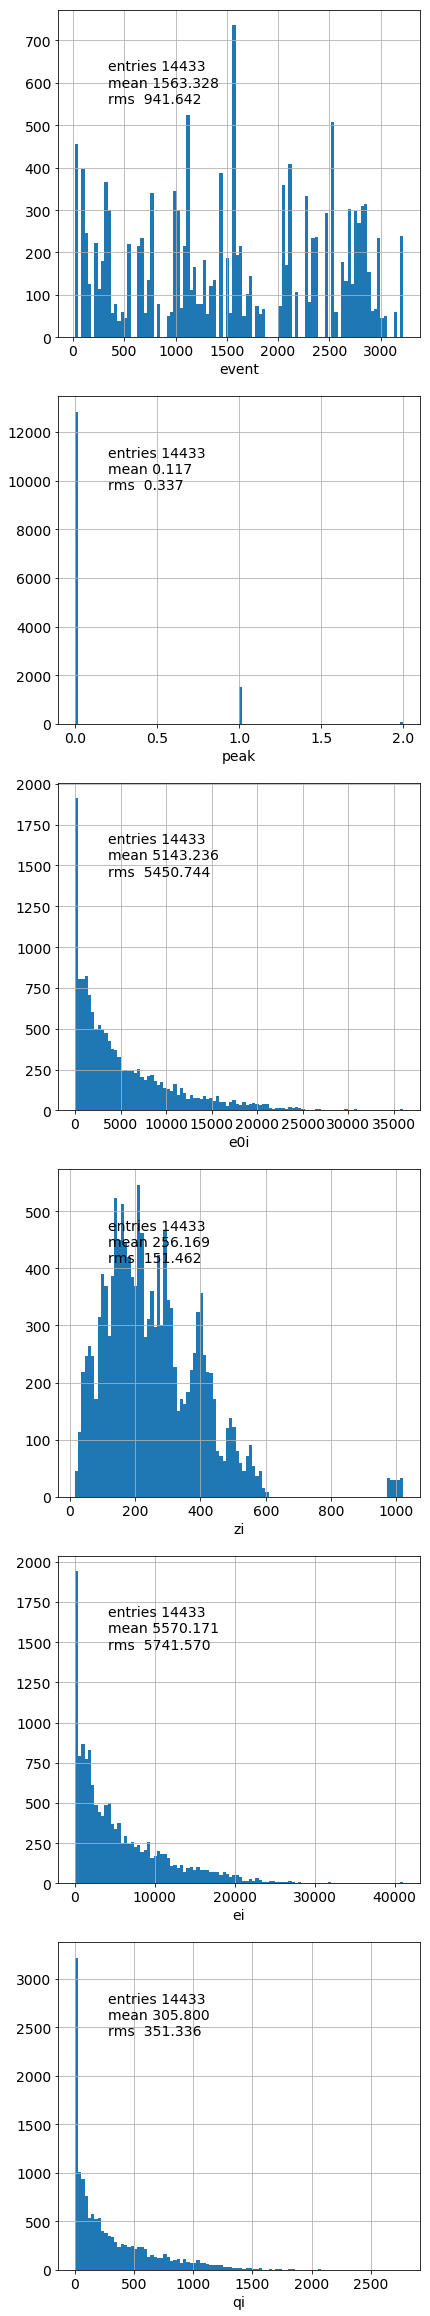

In [56]:
cpkplot.df(sdf)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


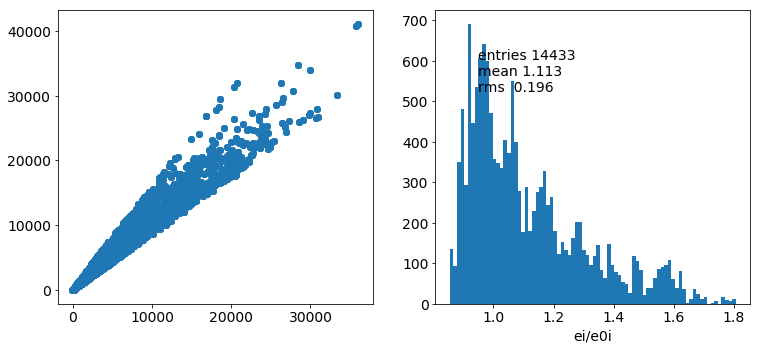

In [57]:
cpkplot.ratio(sdf, [('e0i', 'ei') ], 80)

In [58]:
hdf.head()

,event,peak,xij,yij,zij,q0ij,eij,qij
0,16,0,-55.0,165.0,188.383118,6.022127,129.419530,7.032299
1,16,0,-55.0,165.0,189.368896,10.381000,210.390237,12.128582
2,16,0,-55.0,165.0,190.350281,7.800088,168.971028,9.117858
3,16,0,-55.0,165.0,200.405762,6.595663,162.733623,7.750523
4,16,0,-55.0,165.0,202.376892,7.685381,171.975304,9.040340


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


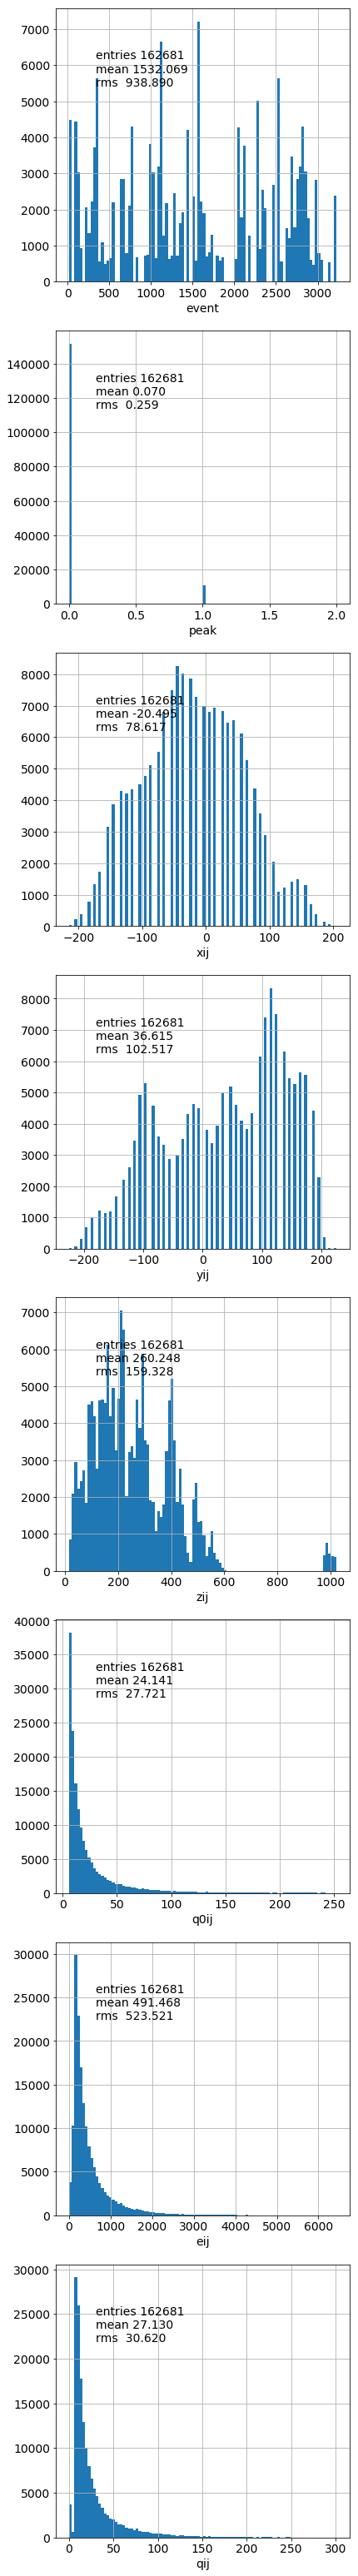

In [59]:
cpkplot.df(hdf)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


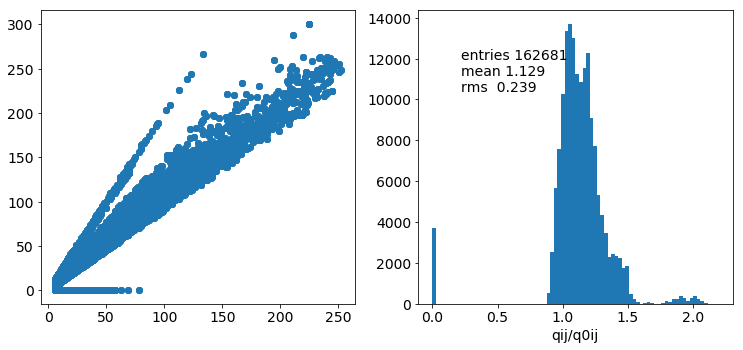

In [60]:
cpkplot.ratio(hdf, [('q0ij', 'qij') ], 80)

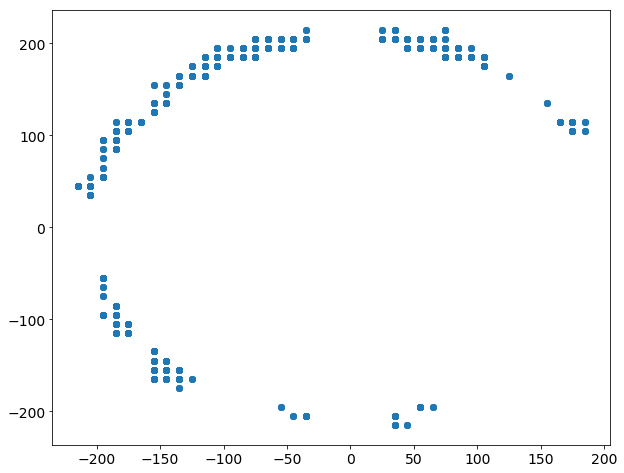

In [61]:
xsel = hdf.qij <= 1.
plt.scatter(hdf.xij[xsel], hdf.yij[xsel]);

[  16  102  107  139  143  158  228  262  293  300  318  324  331  343
  355  390  401  459  465  524  533  552  636  652  674  680  711  733
  753  761  765  841  922  951  985 1007 1015 1019 1032 1046 1089 1103
 1106 1110 1119 1121 1123 1141 1144 1185 1197 1213 1262 1287 1311 1358
 1363 1378 1447 1451 1456 1515 1519 1543 1562 1566 1568 1572 1580 1616
 1618 1645 1653 1704 1719 1733 1809 1817 1875 2031 2038 2057 2067 2073
 2088 2108 2181 2266 2276 2280 2295 2349 2367 2386 2461 2483 2520 2526
 2538 2541 2543 2563 2625 2639 2649 2651 2681 2688 2731 2733 2747 2768
 2773 2781 2789 2795 2819 2833 2845 2853 2857 2869 2875 2895 2923 2946
 2972 2998 3008 3057 3151 3206 3223]


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


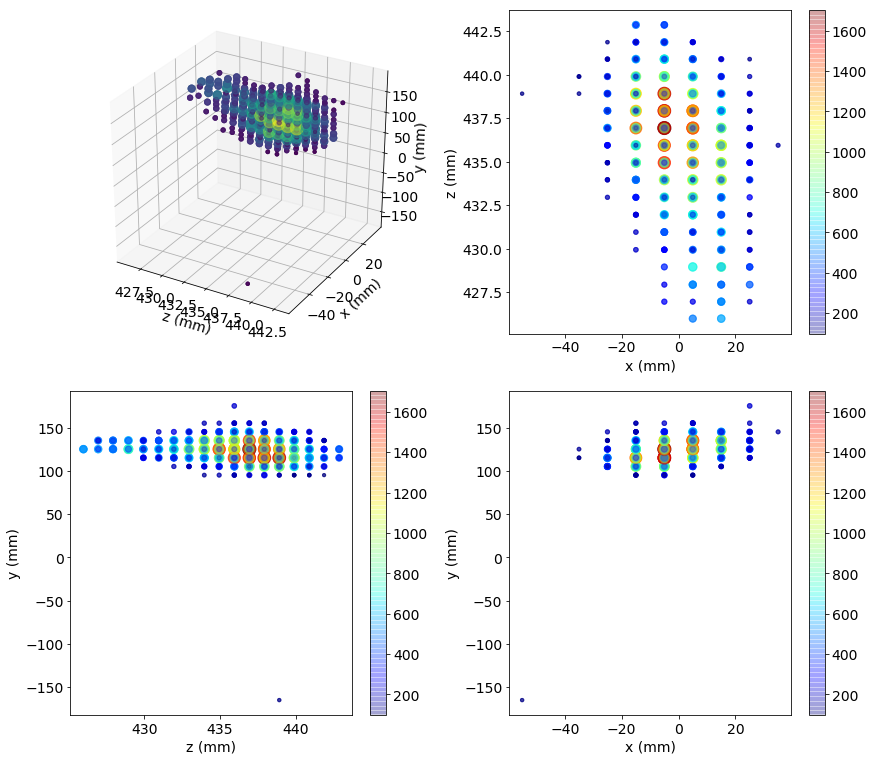

In [62]:
print(np.unique(hdf.event))
evt, pk = 139, 0
sel =  (hdf.event == evt) & (hdf.peak == pk)
cpkplot.graph_event(hdf[sel].xij, hdf[sel].yij, hdf[sel].zij, hdf[sel].eij)

In [63]:
print('Done!')

Done!
